In [22]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 280.9/460.4 GB disk)


In [23]:
from ultralytics import YOLO
from tqdm import tqdm
import cv2

In [24]:
# Verify person_only dataset from Phase 2
person_only_path = Path(f"../{config['paths']['person_only']}")
person_image_count = len(list(person_only_path.glob('*.png')))
print(f"Total images in person_only: {person_image_count}")

Total images in person_only: 721


---
# Phase 3: Full-body Detection
Dataset requirement: 
- Full-body person crops only (No feet or hands are acceptable)
- The face (frontal or side view) must be visible 

## Method Selection

**Bounding Box Check**: Fast but unreliable—loose bbox padding causes false rejections even when feet/head are visible in image

**Pose Estimation (Selected)**: Detects actual keypoints—robust to loose bboxes and clothing occlusion. Allows missing feet/hands (per requirement).

---

## Model: YOLOv8-Pose

**Why YOLOv8-Pose**:
- Already integrated (Phase 2 framework consistency)
- Pre-trained on COCO with proven accuracy—no training needed
- Fast (~50ms/image), detects all 17 keypoints
- Single tuning parameter (keypoint threshold 0.5)

Alternatives: MediaPipe Pose (comparable but different ecosystem), HRNet (slower, overkill for binary check)

**Keypoint threshold (0.5)**: Standard confidence threshold for production pose detection—balances precision/recall

---
## Define Full-Body Validation Function

In [25]:
def is_fullbody_person(img, pose_model, keypoint_threshold=0.5):
    """
    Check if image contains a full-body person.
    
    Requirement: "Full-body person crops only"
    - Head visible (nose keypoint detected)
    - Legs visible (knees or ankles detected)
    - Missing feet/hands is acceptable (e.g., long pants covering ankles)
    
    Args:
        img: Pre-cropped person image array (BGR)
        pose_model: YOLOv8-Pose model
        keypoint_threshold: Confidence threshold for pose keypoints (default: 0.5)
    
    Returns:
        dict: {
            'is_fullbody': bool (passes pose check),
            'keypoint_confidence': dict (confidence scores for key joints)
        }
    """
    # Run pose detection
    results = pose_model.predict(source=img, verbose=False)
    result = results[0]
    
    if not result.keypoints or len(result.keypoints) == 0:
        return {
            'is_fullbody': False,
            'keypoint_confidence': {}
        }
    
    # Get keypoints for first person
    keypoints = result.keypoints[0]
    
    # COCO keypoint indices:
    # 0=nose, 13=left_knee, 14=right_knee, 15=left_ankle, 16=right_ankle
    nose_conf = keypoints.conf[0, 0].item() if keypoints.conf is not None else 0
    left_knee_conf = keypoints.conf[0, 13].item() if keypoints.conf is not None else 0
    right_knee_conf = keypoints.conf[0, 14].item() if keypoints.conf is not None else 0
    left_ankle_conf = keypoints.conf[0, 15].item() if keypoints.conf is not None else 0
    right_ankle_conf = keypoints.conf[0, 16].item() if keypoints.conf is not None else 0
    
    # Check pose: Head + Legs visible
    has_head = nose_conf > keypoint_threshold
    has_legs = (
        left_knee_conf > keypoint_threshold or 
        right_knee_conf > keypoint_threshold or
        left_ankle_conf > keypoint_threshold or 
        right_ankle_conf > keypoint_threshold
    )
    is_fullbody = has_head and has_legs
    
    return {
        'is_fullbody': is_fullbody,
        'keypoint_confidence': {
            'nose': float(nose_conf),
            'left_knee': float(left_knee_conf),
            'right_knee': float(right_knee_conf),
            'left_ankle': float(left_ankle_conf),
            'right_ankle': float(right_ankle_conf),
        }
    }

## Load Pose Model

In [26]:
# Load pose model and config settings
pose_model_path = Path(config['models']['pose'])
keypoint_threshold = config['pose']['keypoint_threshold']
pose_model = YOLO(f"../{pose_model_path}")

print(f"Loaded pose model: {pose_model_path}")
print(f"Keypoint threshold: {keypoint_threshold}")

Loaded pose model: model/yolov8n-pose.pt
Keypoint threshold: 0.5


## Run Full-Body Validation (Pose-Only)

In [27]:
# Note: Face detection removed - now handled by Phase 4 (Age Estimation)
# Phase 4 uses InsightFace which is more accurate at filtering mannequins/statues

## Run Full-Body Validation

In [28]:
# Run full-body pose detection on all person images
all_results = {}

for img_name in tqdm(person_image_names, desc="Validating full-body"):
    img_path = person_output_path / img_name
    img = cv2.imread(str(img_path))
    
    if img is None:
        continue
    
    # Run pose detection only (face filtering happens in Phase 4)
    result = is_fullbody_person(img, pose_model, keypoint_threshold)
    
    all_results[img_name] = {
        'is_fullbody': result['is_fullbody'],
        'keypoint_confidence': result['keypoint_confidence']
    }

# Summary stats
fullbody_count = sum(1 for r in all_results.values() if r['is_fullbody'])
total_count = len(all_results)
coverage = (fullbody_count / total_count * 100) if total_count > 0 else 0

print(f"\n{'='*50}")
print(f"Full-body pose validation results:")
print(f"  Full-body detected: {fullbody_count}/{total_count} ({coverage:.1f}%)")
print(f"  Not full-body: {total_count - fullbody_count}")
print(f"{'='*50}")
print(f"\nNote: Face detection filtering moved to Phase 4")
print(f"Phase 4 will filter mannequins/statues using InsightFace")
print(f"{'='*50}")

Validating full-body: 100%|██████████| 721/721 [00:18<00:00, 39.04it/s]


Full-body pose validation results:
  Full-body detected: 216/721 (30.0%)
  Not full-body: 505

Note: Face detection filtering moved to Phase 4
Phase 4 will filter mannequins/statues using InsightFace


In [29]:
# Save validated full-body images for Phase 4 (face validation)
validated_path = Path(f"../{config['paths']['validated']}")
if validated_path.exists():
    shutil.rmtree(validated_path)
validated_path.mkdir(exist_ok=True)

saved_count = 0
for img_name, result in all_results.items():
    if result['is_fullbody']:
        source_path = person_output_path / img_name
        shutil.copy(source_path, validated_path / img_name)
        saved_count += 1

print(f"\n{'='*50}")
print(f"Saved {saved_count} full-body validated images to: {config['paths']['validated']}")
print(f"{'='*50}")



Saved 216 full-body validated images to: data/validated


In [30]:
# Verify validated dataset
validated_path = Path(f"../{config['paths']['validated']}")
image_count = len(list(validated_path.glob('*.png')))
print(f"Total images in validated: {image_count}")


Total images in validated: 216


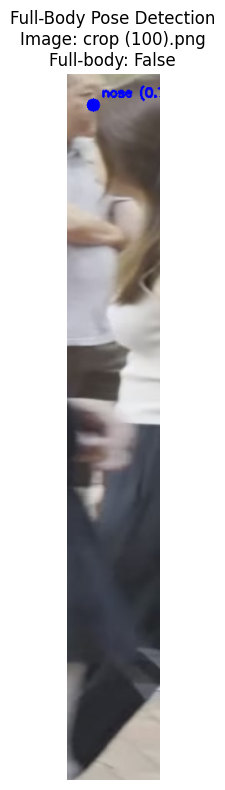

In [31]:
import matplotlib.pyplot as plt

# Select a test image to visualize (uses first result)
if all_results:
    test_image_name = list(all_results.keys())[1]
else:
    print("No results available. Run validation first.")
    test_image_name = None 
    
# Load selected image
if test_image_name in all_results:
    test_img_path = person_output_path / test_image_name
    test_img = cv2.imread(str(test_img_path)).copy()
    test_result = all_results[test_image_name]
    
    # Run pose detection to get keypoints
    results = pose_model.predict(source=test_img, verbose=False)
    result = results[0]
    
    if result.keypoints and len(result.keypoints) > 0:
        keypoints = result.keypoints[0]
        kpts_xy = keypoints.xy[0].cpu().numpy()  # (17, 2) array of (x, y) coordinates
        kpts_conf = keypoints.conf[0].cpu().numpy()  # (17,) array of confidences
        
        # Draw keypoints (nose, knees, ankles)
        keypoint_map = {
            0: ('nose', (255, 0, 0)),           # Red
            13: ('left_knee', (255, 255, 0)),   # Yellow
            14: ('right_knee', (255, 165, 0)),  # Orange
            15: ('left_ankle', (0, 255, 0)),    # Green
            16: ('right_ankle', (0, 0, 255))    # Blue
        }
        
        for kpt_idx, (kpt_name, color) in keypoint_map.items():
            x, y = kpts_xy[kpt_idx]
            conf = kpts_conf[kpt_idx]
            
            if conf > keypoint_threshold:  # Only draw if detected
                cv2.circle(test_img, (int(x), int(y)), 8, color, -1)
                cv2.putText(test_img, f"{kpt_name} ({conf:.2f})", 
                           (int(x) + 10, int(y) - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Display result
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Full-Body Pose Detection\nImage: {test_image_name}\nFull-body: {test_result['is_fullbody']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No keypoints detected!")
else:
    print(f"Image '{test_image_name}' not found in results.")
    print(f"Available images: {person_image_names[:10]}...")


## Validation Logic Summary

**Single-stage filter** (pose-based):
- **Head visible**: Nose keypoint confidence > 0.5
- **Legs visible**: Knee or ankle keypoints confidence > 0.5
- **Allows**: Long pants, skirts, missing feet/hands (per requirement)

**Mannequin filtering**: Now handled by Phase 4
- Phase 4 uses InsightFace face detection (more accurate)
- Rejects images where face cannot be detected
- Result: More accurate filtering of non-human objects

**Design rationale**:
- Binary classification (full-body: yes/no) based on pose keypoints only
- Pre-trained YOLOv8-Pose on standard benchmarks (COCO) sufficient
- Mannequin/statue filtering moved to Phase 4 (InsightFace is more accurate)
- Cleaner separation of concerns: Phase 3 = pose, Phase 4 = age + face validation